In [1]:
import numpy as np
import torch
from torch import Tensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
D = 784
dim = D
z_dim = 100

Sphi = torch.zeros((z_dim), requires_grad=True)
St = torch.zeros((z_dim), requires_grad=True) # varience of z

Fk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(dim, dim),
    torch.nn.Sigmoid()
)

Q = torch.nn.Sequential(
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, z_dim)
)

In [4]:
from itertools import chain
from healing_mnist import HealingMNIST

In [5]:
mnist = HealingMNIST()

X_train = Tensor(mnist.train_images.reshape(60000, 5, 784).astype(int))
U_train = Tensor(np.transpose(np.stack([np.sin((mnist.train_rotations / 180.) * np.pi * i) for i in range(25)] + [np.cos((mnist.train_rotations / 180.) * np.pi * i) for i in range(25)]), axes=[1, 2, 0]))

In [6]:
Gk = torch.nn.GRUCell(50*5, 100*5)

In [7]:
from tqdm import tqdm_notebook

T = 5
delta = 1

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
l = []

for k in tqdm_notebook(range(1000)):
    
    batch_x = X_train[(k%1000)::1000] 

    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    # logp += (T-1) * D * torch.log(delta) * torch.prod(St)
    logp -= T * torch.sum(torch.log(SphiPos))   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    
    mu_q_t = Q(batch_x)
    
    logp += torch.mean(torch.sum((mu_q_t[:, 0, :] * mu_q_t[:, 0, :]), dim=1))
    
    # shape [50, 5, 784], random
    sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((5, z_dim)), 
                                                torch.ones((5, z_dim))))
    # shape [50, 4, 784], random
    Gt_t_2T = Gk(U_train[:60].reshape(60, -1), Q(X_train[:60]).reshape(60, -1)).reshape(60, 5, -1)

    # 0.02 = (1/50) - averaging over random sample
    logp += (1/60.)*torch.sum(((Gt_t_2T[:, :4, :] - mu_q_t[:, 1:, :]) * (Gt_t_2T[:, :4, :] - mu_q_t[:, 1:, :]) / StPos))
    logp *= 0.5

    p = Fk(sample_z)
    loss = logp + torch.nn.functional.binary_cross_entropy(input=p.reshape(-1, T*784), target=batch_x.reshape(-1, T*784))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)

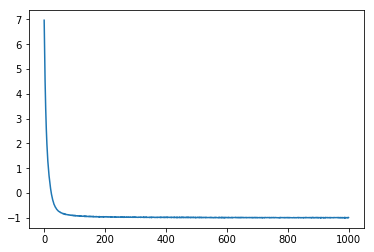

In [8]:
plt.plot(l)
# plt.ylim([-1.05, -0.95])

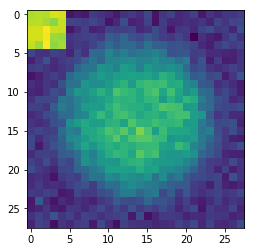

In [9]:
plt.imshow(Fk(Q(X_train[7]))[0].detach().reshape(28, 28))